# NYC Yellow Taxi Trips

The New York City Taxi & Limousine Commission provides data on trips taken via yellow, green, and for-hire vehicles such as Uber and Lyft. This project focuses on the Yellow Taxi industry. The data is stored in parquet files and will be read into pandas for data manipulation. The goal of this project is to analyze how the industry's network of trips (edges) flows throughout the city based on pickup and dropoff locations (nodes). Utilizing centrality measures such as degree and eigenvector centrality, we aim to identify potential differences in trip patterns based on payment methods, specifically cash versus credit card.

Our hypothesis is that the most important nodes will differ depending on the payment method. For credit card transactions, longer-distance trips, such as those between the city and airports, will likely highlight airport nodes as the most important. For cash transactions, intra-city trips such as those between Times Square and Wall Street—will be more significant, as these trips tend to be shorter, making cash payments more convenient.

It is important to note that the records being used will **only be for January 2024** due to the size of each data file. Also, a data dictionary of what each column represents can be found [here](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

## Import Packages

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random

## Import Trips Data

We can see we have a lot of data that needs to be parsed down for this network analysis. The most important features will be pickup location(**PULocationID**), dropoff location (**DOLocationID**) and payment type (**payment_type**)

In [151]:
trips_df = pd.read_parquet('yellow_tripdata_2024-01.parquet')

In [152]:
trips_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


## Import Location Data
We also have each locationID and what borough and zone it represents. 

In [153]:
location_df = pd.read_csv('taxi_zone_lookup.csv')
location_df.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


## Data Exploration

### Missing Values

We can see that some columns have missing values such as passenger counts, ratecodeID and airport_fee. Fortunately these columns are not of importance in this analysis.

In [154]:
trips_df.isna().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          140162
trip_distance                 0
RatecodeID               140162
store_and_fwd_flag       140162
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     140162
Airport_fee              140162
dtype: int64

### Total Trips

We have a total of almost 3 million trips taken. We can also see that pickup location 132 has the highest amount of trips being picked up from.

In [155]:
trips_df['PULocationID'].count()

np.int64(2964624)

In [156]:
top_pickup_trips = trips_df.groupby('PULocationID')['DOLocationID'].agg(total_trips = 'count').reset_index(drop=False).sort_values(by='total_trips', ascending=False)
top_pickup_trips

,PULocationID,total_trips
126,132,145240
155,161,143471
231,237,142708
230,236,136465
156,162,106717
...,...,...
105,111,1
42,44,1
100,105,1
198,204,1


To have some more clarity of the top 10 trips being picked up from, we will join our location data with it. 

Not surprisingly, JFK Airport has the highest amount of trips being picked up from. However, NYC's other airport, LaGuardia Aiport, falls down to 8th place with Manhattan's Midtown Center coming in 2nd instead. Some reasoning behind this is given how central of a hub Midtown is to all of NYC but definitely raises questions if it is truly as important in the network.

In [157]:
merged_df = pd.merge(top_pickup_trips, location_df, left_on='PULocationID', right_on='LocationID')
merged_df.head(10)

,PULocationID,total_trips,LocationID,Borough,Zone,service_zone
0,132,145240,132,Queens,JFK Airport,Airports
1,161,143471,161,Manhattan,Midtown Center,Yellow Zone
2,237,142708,237,Manhattan,Upper East Side South,Yellow Zone
3,236,136465,236,Manhattan,Upper East Side North,Yellow Zone
4,162,106717,162,Manhattan,Midtown East,Yellow Zone
5,230,106324,230,Manhattan,Times Sq/Theatre District,Yellow Zone
6,186,104523,186,Manhattan,Penn Station/Madison Sq West,Yellow Zone
7,142,104080,142,Manhattan,Lincoln Square East,Yellow Zone
8,138,89533,138,Queens,LaGuardia Airport,Airports
9,239,88474,239,Manhattan,Upper West Side South,Yellow Zone


### Payment Methods

We discover that most trips payment method is 1 (**Credit Card**), with over 2.3 million transactions, followed by 2 (**Cash**) payments of under 0.5 millions transactions. We also see there are other categories such as 3 (**No Charge**) and 4 (**Dispute**). Given the constraints of our analysis, trips not ending with a credit card or cash transaction will be removed.

In [158]:
payment_trips = trips_df.groupby('payment_type')['payment_type'].agg(total = 'count').reset_index(drop=False).sort_values(by='total', ascending=False)
payment_trips

,payment_type,total
1,1,2319046
2,2,439191
0,0,140162
4,4,46628
3,3,19597


## Data Wrangling

We will remove trips that did not end with a credit card or cash transaction. Also, columns not needed in this analysis will be dropped as well.

In [159]:
drop_columns = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 
                'RatecodeID', 'store_and_fwd_flag', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
               'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']
drop_trips_df = trips_df[trips_df['payment_type'].isin([1, 2])].drop(columns=drop_columns)
drop_trips_df.head()

,PULocationID,DOLocationID,payment_type
0,186,79,2
1,140,236,1
2,236,79,1
3,79,211,1
4,211,148,1


Next, we will replace our numeric payment type to its appropriate string value

In [160]:
drop_trips_df['payment_type'] = drop_trips_df['payment_type'].apply(lambda x: 'Credit Card' if x==2 else 'Cash')
drop_trips_df.head()

,PULocationID,DOLocationID,payment_type
0,186,79,Credit Card
1,140,236,Cash
2,236,79,Cash
3,79,211,Cash
4,211,148,Cash


Let's add a column developing trip counts based on a pickup to dropoff location and its payment type. This will be important later on as we will use it as a weight in our network. 

In [161]:
drop_trips_df['trip_count'] = 1
cleaned_trips_df = drop_trips_df.groupby(['PULocationID', 'DOLocationID', 'payment_type'])['trip_count'].agg('count').reset_index()
cleaned_trips_df.head()

,PULocationID,DOLocationID,payment_type,trip_count
0,1,1,Cash,229
1,1,1,Credit Card,12
2,1,6,Cash,1
3,1,48,Credit Card,1
4,1,68,Cash,1


## Yellow Taxi Trips (Credit Card)

We will begin our first network graph setup with credit card transactions. We are looking to measure a network's most important nodes using both degree and eigenvector centrality. The graph will be a directed, weighted graph using **trip_counts** as its weights and the direction of a **PULocationID** to **DOLocationID** trip. 

In [162]:
cc_trips = cleaned_trips_df[cleaned_trips_df['payment_type'] == 'Credit Card']
cc_trips.head()

,PULocationID,DOLocationID,payment_type,trip_count
1,1,1,Credit Card,12
3,1,48,Credit Card,1
10,1,265,Credit Card,5
14,3,3,Credit Card,6
57,3,242,Credit Card,1


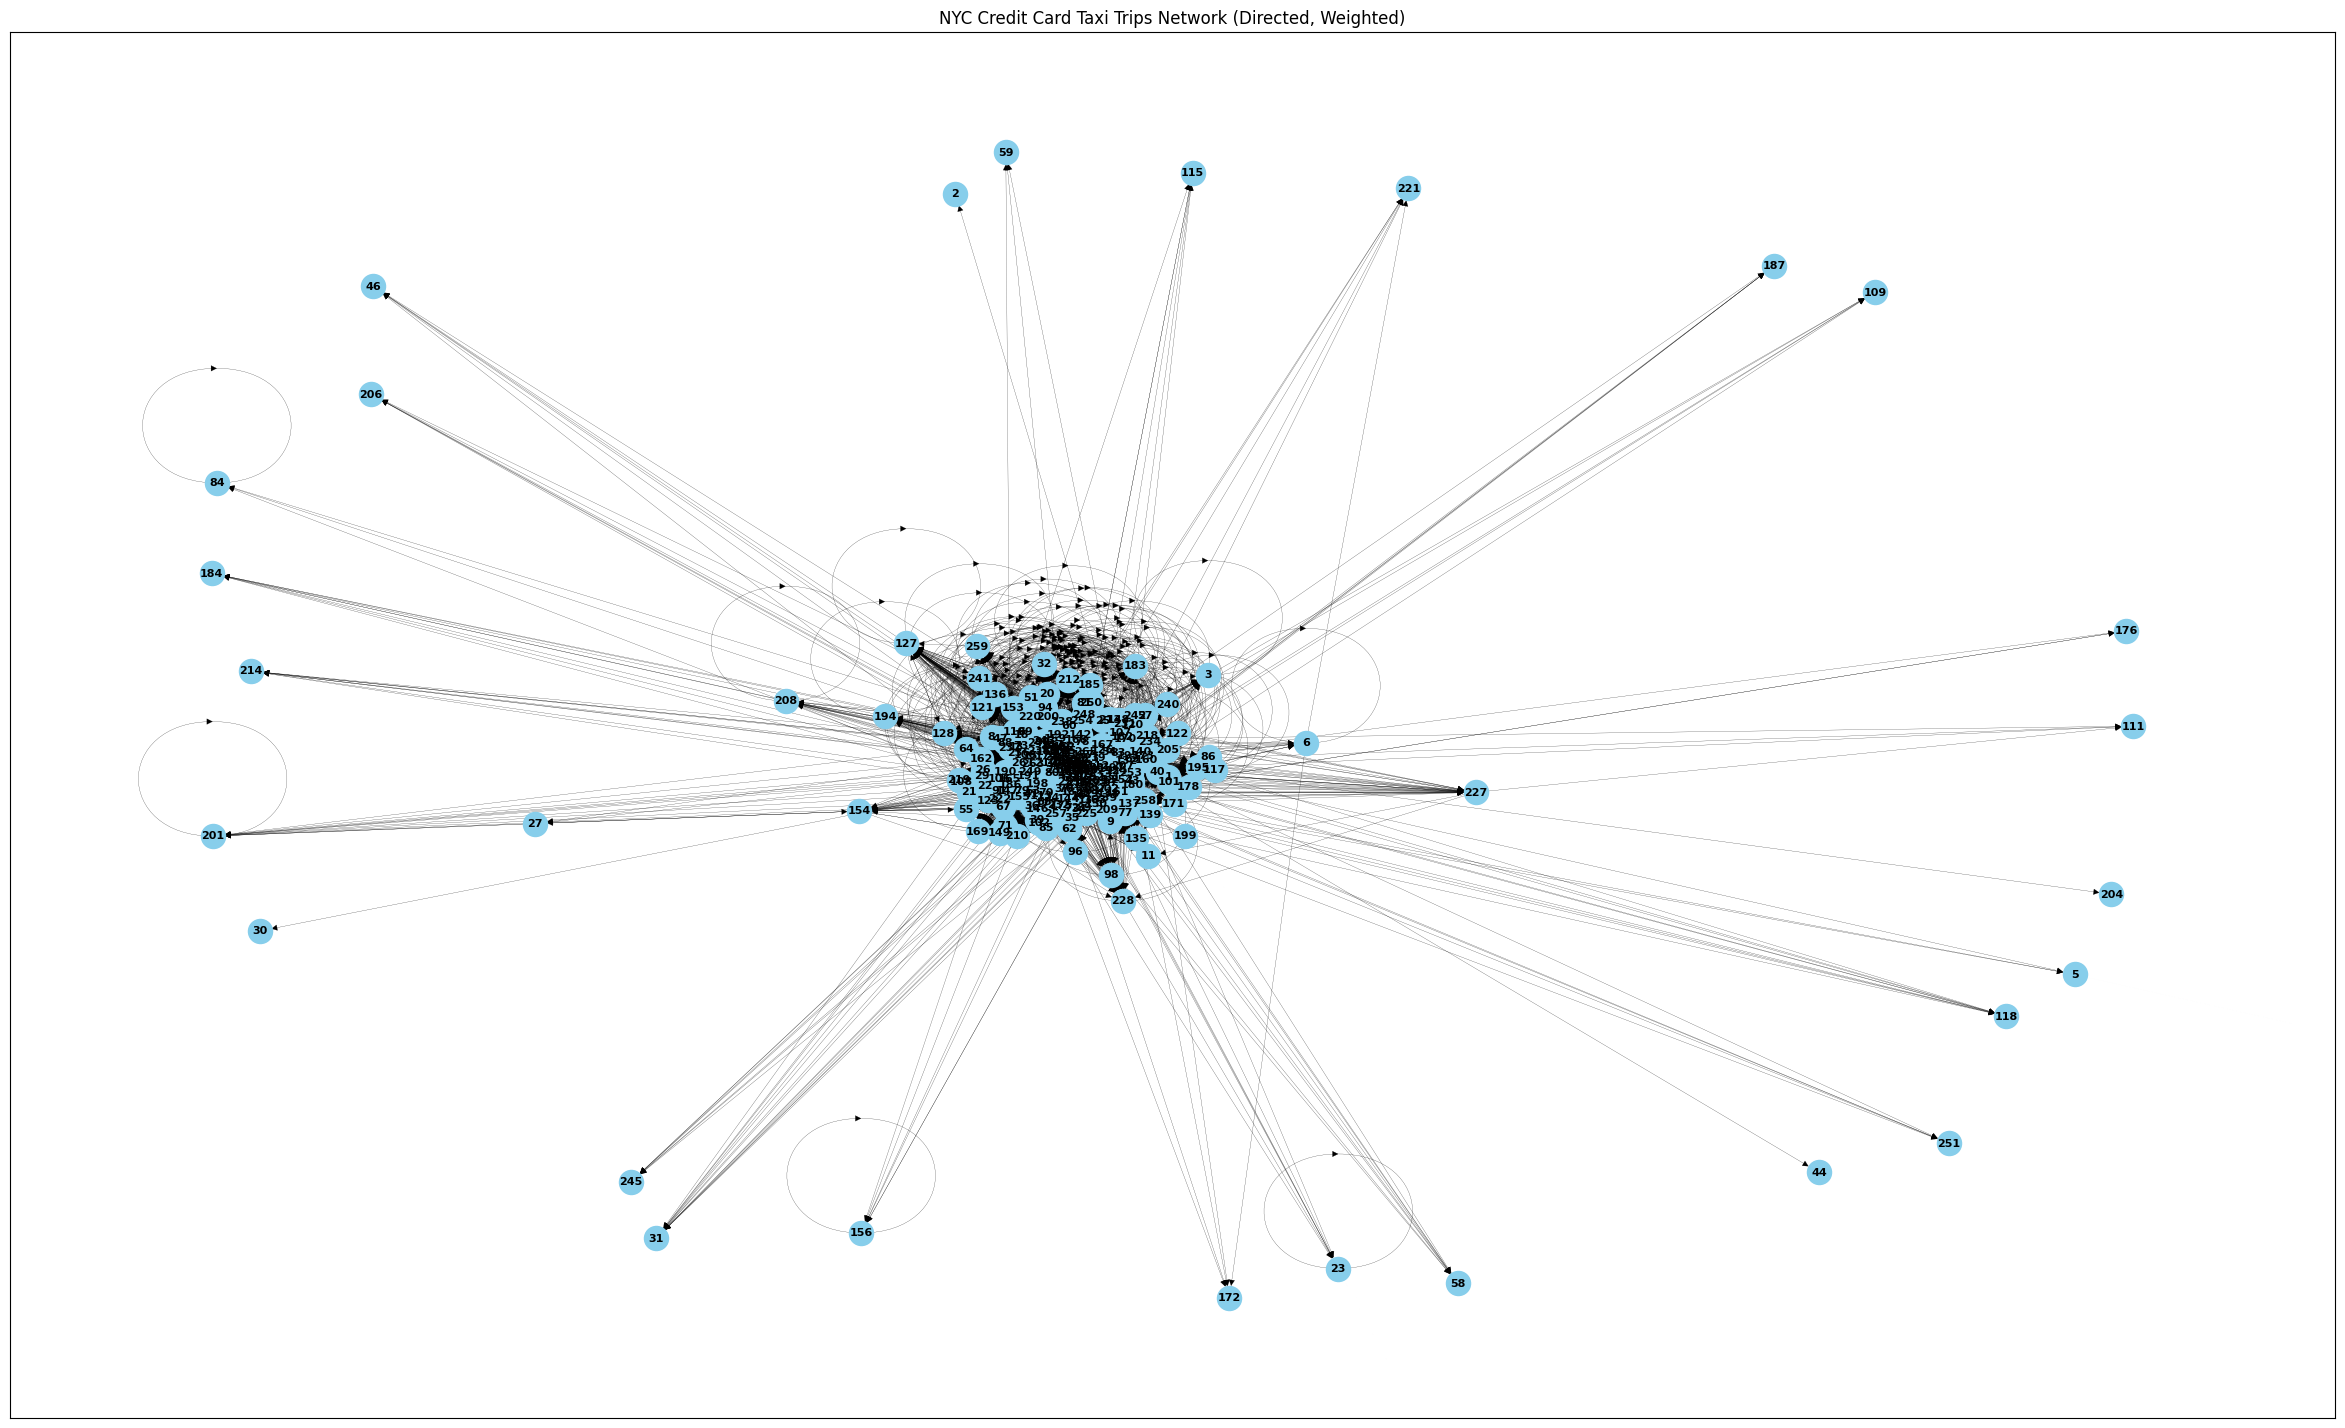

In [168]:
G = nx.from_pandas_edgelist(cc_trips, source='PULocationID', target='DOLocationID', 
                            edge_attr='trip_count', create_using=nx.DiGraph())

pos = nx.spring_layout(G, seed=123)  

fig, ax = plt.subplots(figsize=(30, 18))

nx.draw_networkx_nodes(G, pos, node_size=300, node_color="skyblue")
nx.draw_networkx_edges(G, pos, edgelist=edges, width=0.15)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")

plt.title("NYC Credit Card Taxi Trips Network (Directed, Weighted)")
plt.show()

### Degree Centrality

Looking at the node with the highest degree centrality, we find that **node 132** is the most important node by this measure and it had 380 edges connected to it. 

In [165]:
top_degree_centrality = max(nx.degree_centrality(G), key=nx.degree_centrality(G).get)
print(f"Highest Degree Centrality: {top_degree_centrality}")
print("Number of Edges:", G.degree(132))

Highest Degree Centrality: 132
Number of Edges: 380


We can see that **node 132** lies within the central cluster of nodes in our graph

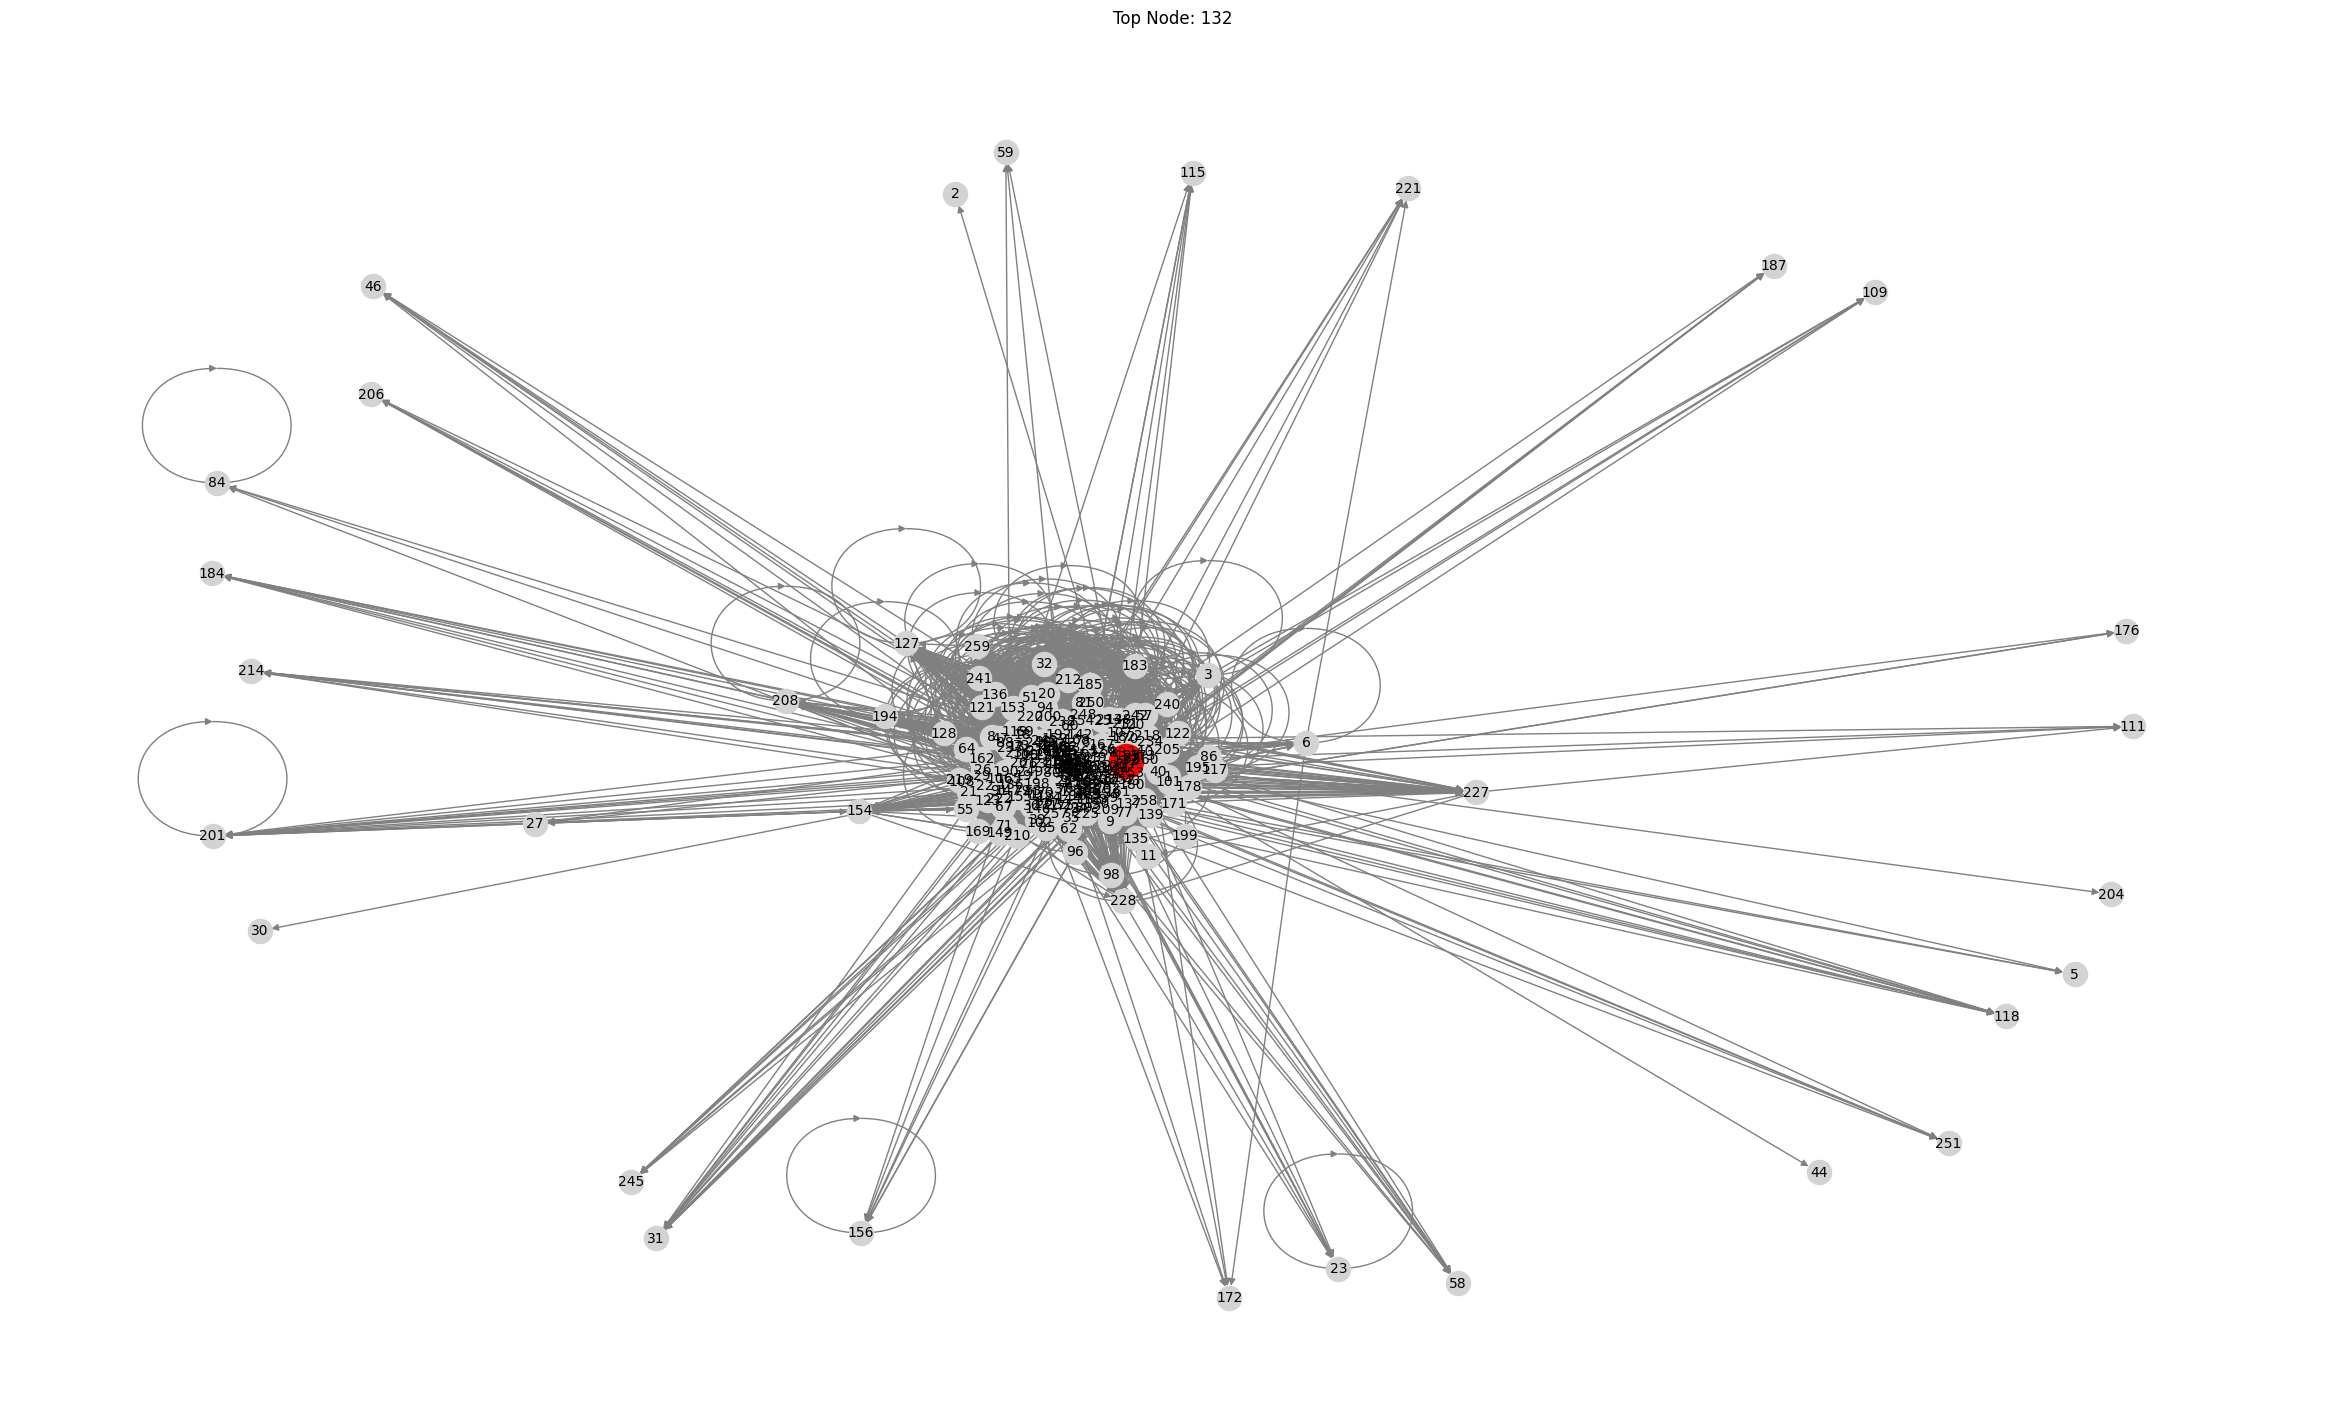

In [166]:
pos = nx.spring_layout(G, seed=123)  

fig, ax = plt.subplots(figsize=(30, 18))

nx.draw(G, pos, with_labels=True, node_color="lightgray", edge_color="gray", node_size=300, font_size=10)

nx.draw_networkx_nodes(G, pos, nodelist=[top_degree_centrality], node_color="red", node_size=600)

plt.title(f"Top Node (Degree Centrality): {top_degree_centrality}")
plt.axis('off')
plt.show()

In [132]:
top_cc_trips = cc_trips.copy()
top_cc_trips = top_cc_trips[(top_cc_trips['PULocationID']==132) | (top_cc_trips['DOLocationID']==132)]

As for the top 10 trip counts within **node 132**, we confirm that when using credit cards, most of the trips originated from JFK Airport but also where the dropoffs occur within an airport zone, either within JFK Airport or LaGuardia Airport. This makes sense as there is residential housing or the MTA system nearby JFK Airport, and passengers needing to connect to LaGuardia Airport for another flight that is across the city.

In [180]:
top_10 = top_cc_trips.sort_values(by='trip_count', ascending=False).head(10)
top_10 = top_10.merge(location_df, left_on='PULocationID', right_on='LocationID', 
             how='left').rename(columns={'Borough':'PU_Borough', 'Zone':'PU_Zone', 'service_zone':'PU_Service_Zone'}).drop(columns=['LocationID'])
top_10.merge(location_df, left_on='DOLocationID', right_on='LocationID', 
             how='left').rename(columns={'Borough':'DO_Borough', 'Zone':'DO_Zone', 'service_zone':'DO_Service_Zone'}).drop(columns=['LocationID'])

,PULocationID,DOLocationID,payment_type,trip_count,PU_Borough,PU_Zone,PU_Service_Zone,DO_Borough,DO_Zone,DO_Service_Zone
0,132,132,Credit Card,2866,Queens,JFK Airport,Airports,Queens,JFK Airport,Airports
1,132,230,Credit Card,1529,Queens,JFK Airport,Airports,Manhattan,Times Sq/Theatre District,Yellow Zone
2,132,265,Credit Card,1503,Queens,JFK Airport,Airports,NaN,Outside of NYC,NaN
3,132,216,Credit Card,988,Queens,JFK Airport,Airports,Queens,South Ozone Park,Boro Zone
4,132,10,Credit Card,880,Queens,JFK Airport,Airports,Queens,Baisley Park,Boro Zone
5,132,48,Credit Card,833,Queens,JFK Airport,Airports,Manhattan,Clinton East,Yellow Zone
6,132,138,Credit Card,592,Queens,JFK Airport,Airports,Queens,LaGuardia Airport,Airports
7,230,132,Credit Card,570,Manhattan,Times Sq/Theatre District,Yellow Zone,Queens,JFK Airport,Airports
8,132,219,Credit Card,557,Queens,JFK Airport,Airports,Queens,Springfield Gardens South,Boro Zone
9,132,130,Credit Card,508,Queens,JFK Airport,Airports,Queens,Jamaica,Boro Zone


### Eigenvector Centrality

Looking at the node with the highest eigenvector centrality, we find that **node 237** is the most important node by this measure and it has 245 edges connected to it. 

In [194]:
sorted_eigenvector = sorted(nx.eigenvector_centrality(G, weight='trip_count', max_iter=1000).items(), key=lambda x: x[1], reverse=True)

for node, centrality in sorted_eigenvector[:5]:
    print(f"Node {node}: {centrality}")
    print("Number of Edges:", G.degree(node))
    print("------")

Node 237: 0.3758894708525081
Number of Edges: 245
------
Node 236: 0.36114863809739506
Number of Edges: 230
------
Node 161: 0.30042323232374846
Number of Edges: 270
------
Node 230: 0.2698255418689706
Number of Edges: 288
------
Node 162: 0.21638382350831786
Number of Edges: 256
------


Looking deeper into our top node, we see that **node 237** is the Upper East Side South Zone. Most of the trips are either short trips taken within itself or from the Upper East Side North Zone and accounts for over 8,000 trips compared to the other zones listed. 

In [193]:
top_cc_trips = cc_trips.copy()
top_cc_trips = top_cc_trips[(top_cc_trips['PULocationID']==237) | (top_cc_trips['DOLocationID']==237)]

top_10 = top_cc_trips.sort_values(by='trip_count', ascending=False).head(10)
top_10 = top_10.merge(location_df, left_on='PULocationID', right_on='LocationID', 
             how='left').rename(columns={'Borough':'PU_Borough', 'Zone':'PU_Zone', 'service_zone':'PU_Service_Zone'}).drop(columns=['LocationID'])
top_10.merge(location_df, left_on='DOLocationID', right_on='LocationID', 
             how='left').rename(columns={'Borough':'DO_Borough', 'Zone':'DO_Zone', 'service_zone':'DO_Service_Zone'}).drop(columns=['LocationID'])

,PULocationID,DOLocationID,payment_type,trip_count,PU_Borough,PU_Zone,PU_Service_Zone,DO_Borough,DO_Zone,DO_Service_Zone
0,237,236,Credit Card,2757,Manhattan,Upper East Side South,Yellow Zone,Manhattan,Upper East Side North,Yellow Zone
1,237,237,Credit Card,2696,Manhattan,Upper East Side South,Yellow Zone,Manhattan,Upper East Side South,Yellow Zone
2,236,237,Credit Card,2362,Manhattan,Upper East Side North,Yellow Zone,Manhattan,Upper East Side South,Yellow Zone
3,161,237,Credit Card,1481,Manhattan,Midtown Center,Yellow Zone,Manhattan,Upper East Side South,Yellow Zone
4,237,161,Credit Card,1366,Manhattan,Upper East Side South,Yellow Zone,Manhattan,Midtown Center,Yellow Zone
5,237,141,Credit Card,1125,Manhattan,Upper East Side South,Yellow Zone,Manhattan,Lenox Hill West,Yellow Zone
6,237,162,Credit Card,1119,Manhattan,Upper East Side South,Yellow Zone,Manhattan,Midtown East,Yellow Zone
7,141,237,Credit Card,1046,Manhattan,Lenox Hill West,Yellow Zone,Manhattan,Upper East Side South,Yellow Zone
8,237,140,Credit Card,972,Manhattan,Upper East Side South,Yellow Zone,Manhattan,Lenox Hill East,Yellow Zone
9,162,237,Credit Card,875,Manhattan,Midtown East,Yellow Zone,Manhattan,Upper East Side South,Yellow Zone


## Yellow Taxi Trips (Cash)

Our second network graph setup will be looking into cash transactions. We are again looking to measure a network's most important nodes using both degree and eigenvector centrality. The graph will be a directed, weighted graph using **trip_counts** as its weights and the direction of a **PULocationID** to **DOLocationID** trip. 